In [1]:
%load_ext autoreload
%autoreload 2

# Intro to 4D-STEM data: Bragg disk detection



### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)


Updated 11/3/2022

## Set up the environment

In [2]:
import py4DSTEM
from py4DSTEM.visualize import show
py4DSTEM.__version__

'0.14.0'

In [3]:
py4DSTEM.check_config()

Checking Module Dependencies
 All Dependencies for Base are Installed 
 Not All Dependencies for Ipyparallel are Installed
 Not All Dependencies for Cuda are Installed
 Not All Dependencies for Acom are Installed
 Not All Dependencies for Aiml are Installed
 Not All Dependencies for Aiml-cuda are Installed
 Not All Dependencies for Numba are Installed


---
# Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (501 megabytes)
* [Simulated single crystal and polycrystalline gold](https://drive.google.com/file/d/1PmbCYosA1eYydWmmZebvf6uon9k_5g_S/view?usp=sharing)

# Load data

Load the same datacube as in the previous notebook, and additionally, load all the results produced in that notebook.

In [4]:
# Set the filepath

from os.path import splitext

filepath_data = "/Users/Ben/work/data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/data_binned.h5"
filepath_basics_01 = splitext(filepath_data)[0] + '_analysis_basics_01.h5'

In [5]:
# Load the datacube

datacube = py4DSTEM.read(
    filepath_data,
    data_id = 'polyAu_4DSTEM'
)

datacube

DataCube( A 4-dimensional array of shape (100, 84, 125, 125) called 'polyAu_4DSTEM',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

In [6]:
# Load the prior analysis

basics_01 = py4DSTEM.read(
    filepath_basics_01
)

basics_01.tree()

/
|---annular_dark_field
|---bright_field
|---dp_max
|---dp_mean
|---virt_dark_field_01
|---virtual_diffracton


# Basic visualization

Show some of the data retrieved from the previous analysis

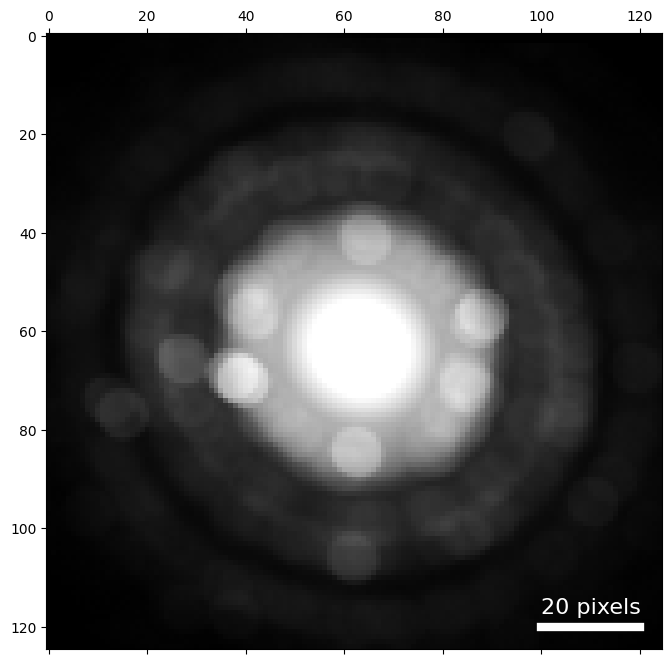

In [7]:
# Mean diffraction

show(
    basics_01.tree('dp_mean'),
    scaling='log',
)

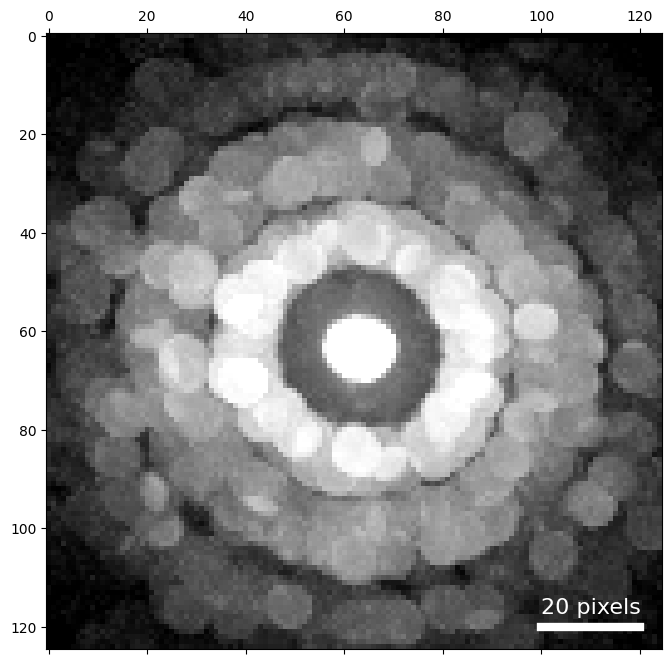

In [8]:
# Max diffraction

show(
    basics_01.tree('dp_max'),
    scaling='log',
)

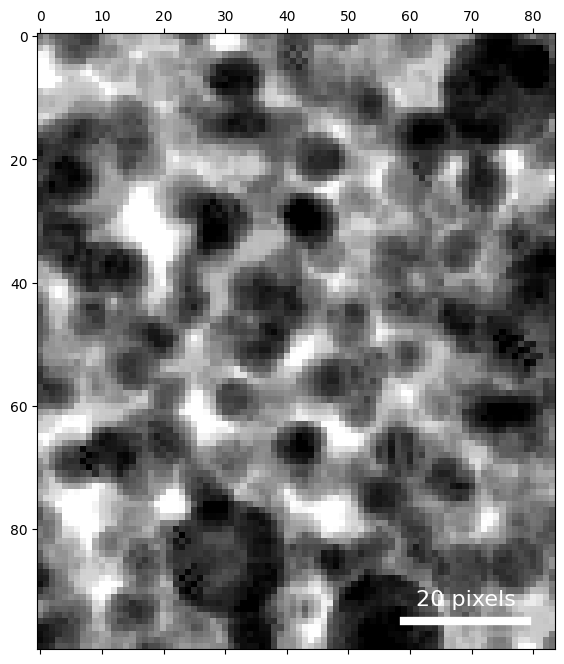

In [9]:
# Virtual BF

# show
show( basics_01.tree( 'bright_field' ) )

# Disk detection

We'll perform disk detection using template matching.  The mathematical machinery here is the cross correlation - if we compute the cross correlation of a template with an image, the maxima of the resulting correlogram correspond to the positions in the image that are good matches to the template.

The steps are:

- get a template (the vacuum electron probe)
- prepare the template for cross correlation (generate a cross correlation kernel from the probe)
- select a few scan position and use them to refine parameters for the disk detection algorithm
- find all the disks

## Generage a probe template

There are a number of ways to get a probe.  If you're running an experiment, the best thing to do is to collect a separate dataset of the probe over vacuum.  It need not be large, but collecting at least a few up to ~a hundred patterns to average over is useful.

Here, we'll select a region of the scan we have that's approximately over vacuum - it contains no gold particles, so only the thin amorphous support should be present - and use these scan positions to compute our probe.

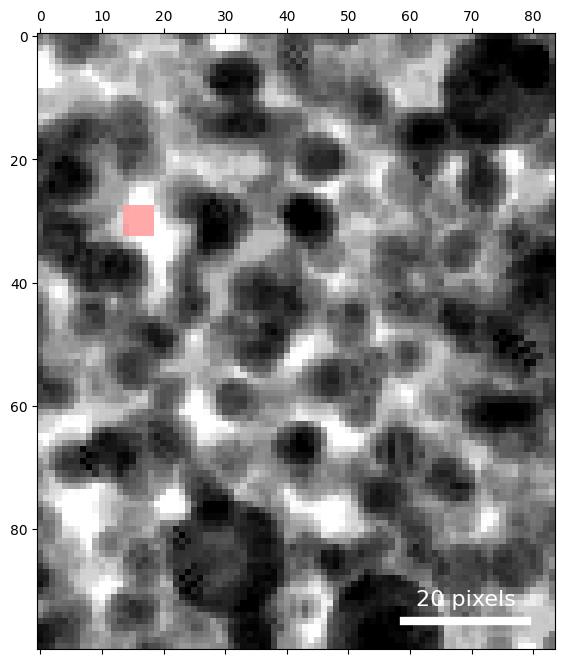

In [10]:
# find a vacuum region

import numpy as np
mask = np.zeros(datacube.Rshape,dtype=bool)
mask[28:33,14:19] = 1


show(
    basics_01.tree('bright_field'),
    mask = ~mask,
    mask_alpha = 0.667,
    mask_color = 'r'
)

100%|███████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 337.46it/s]


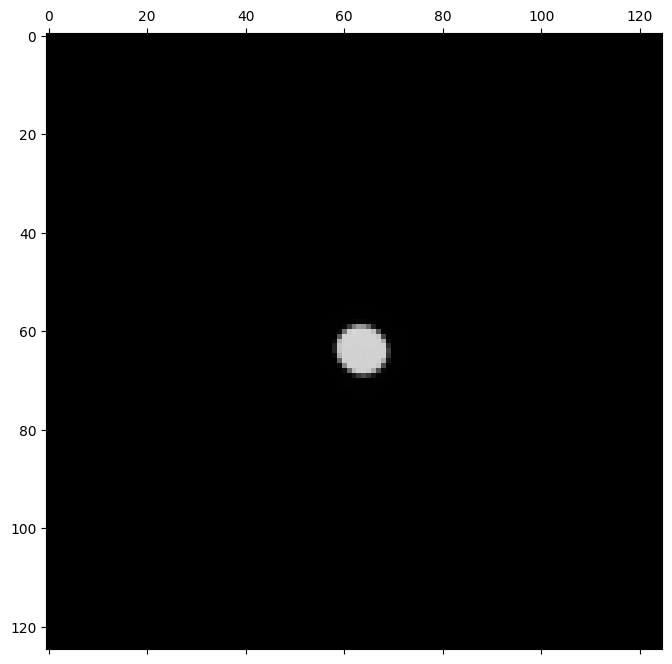

In [11]:
# generate a probe

probe = datacube.get_vacuum_probe( ROI=mask )

show(probe.probe, scaling='none', intensity_range='absolute', vmin=0, vmax=7.8e3)

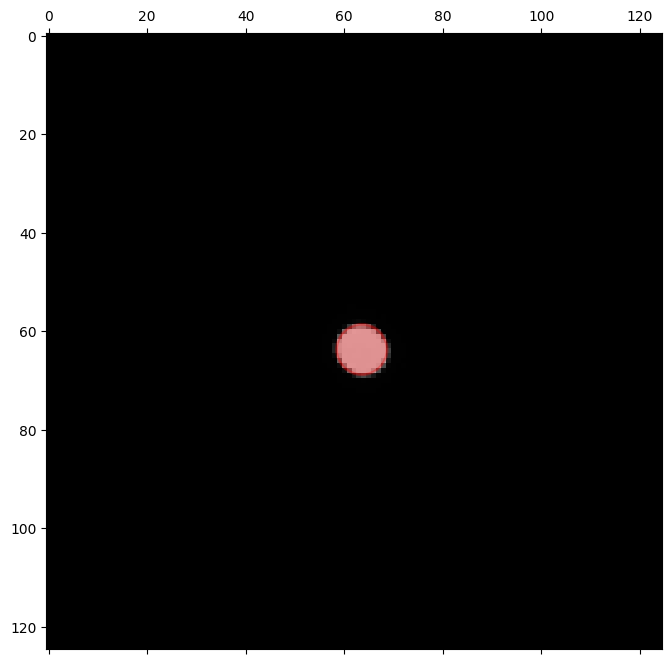

In [12]:
# Find the center and semiangle

alpha_pr,qx0_pr,qy0_pr = py4DSTEM.process.probe.get_probe_size( probe.probe )

show(
    probe.probe, 
    scaling='none',
    intensity_range='absolute',
    vmin=0,vmax=7.8e3,
    circle = {
      'center':(qx0_pr,qy0_pr),
      'R': alpha_pr,
      'alpha':0.3,
      'fill':True
    }
)

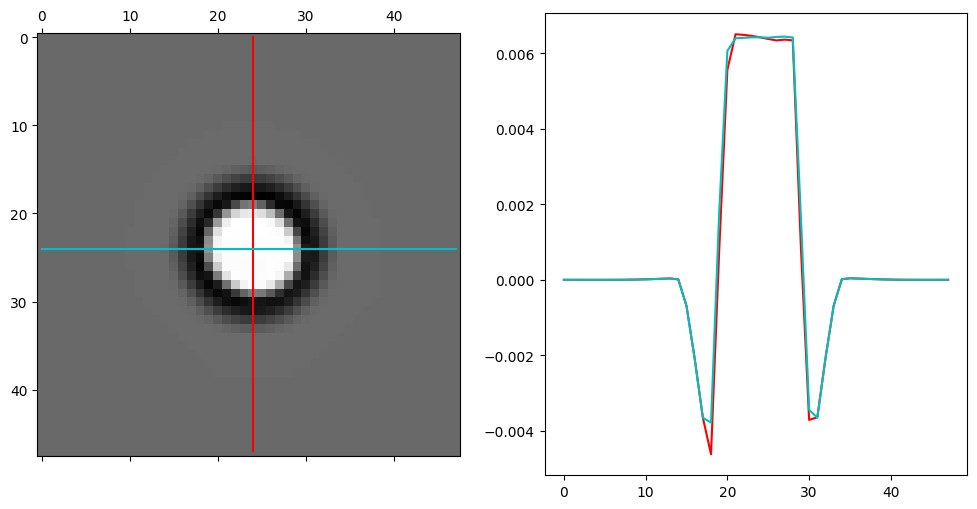

In [13]:
# prepare the probe kernel

probe.get_kernel(
    mode='sigmoid',
    origin=(qx0_pr,qy0_pr),
    radii=(alpha_pr,2*alpha_pr)
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 24,
    L = 24,
    W = 1
)

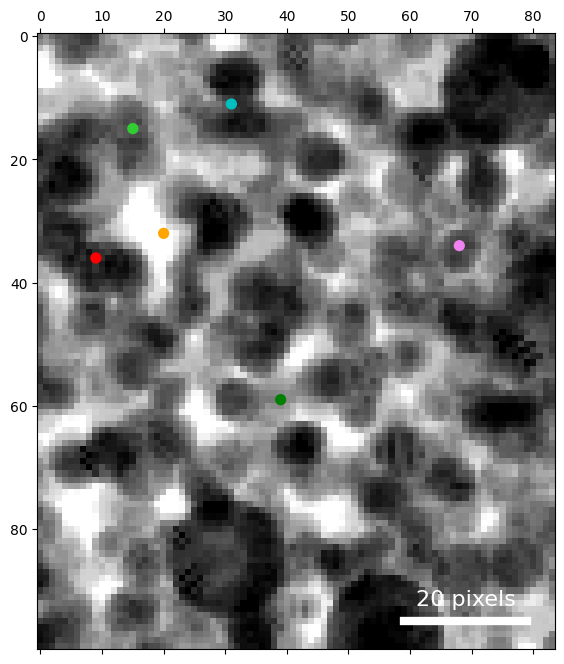

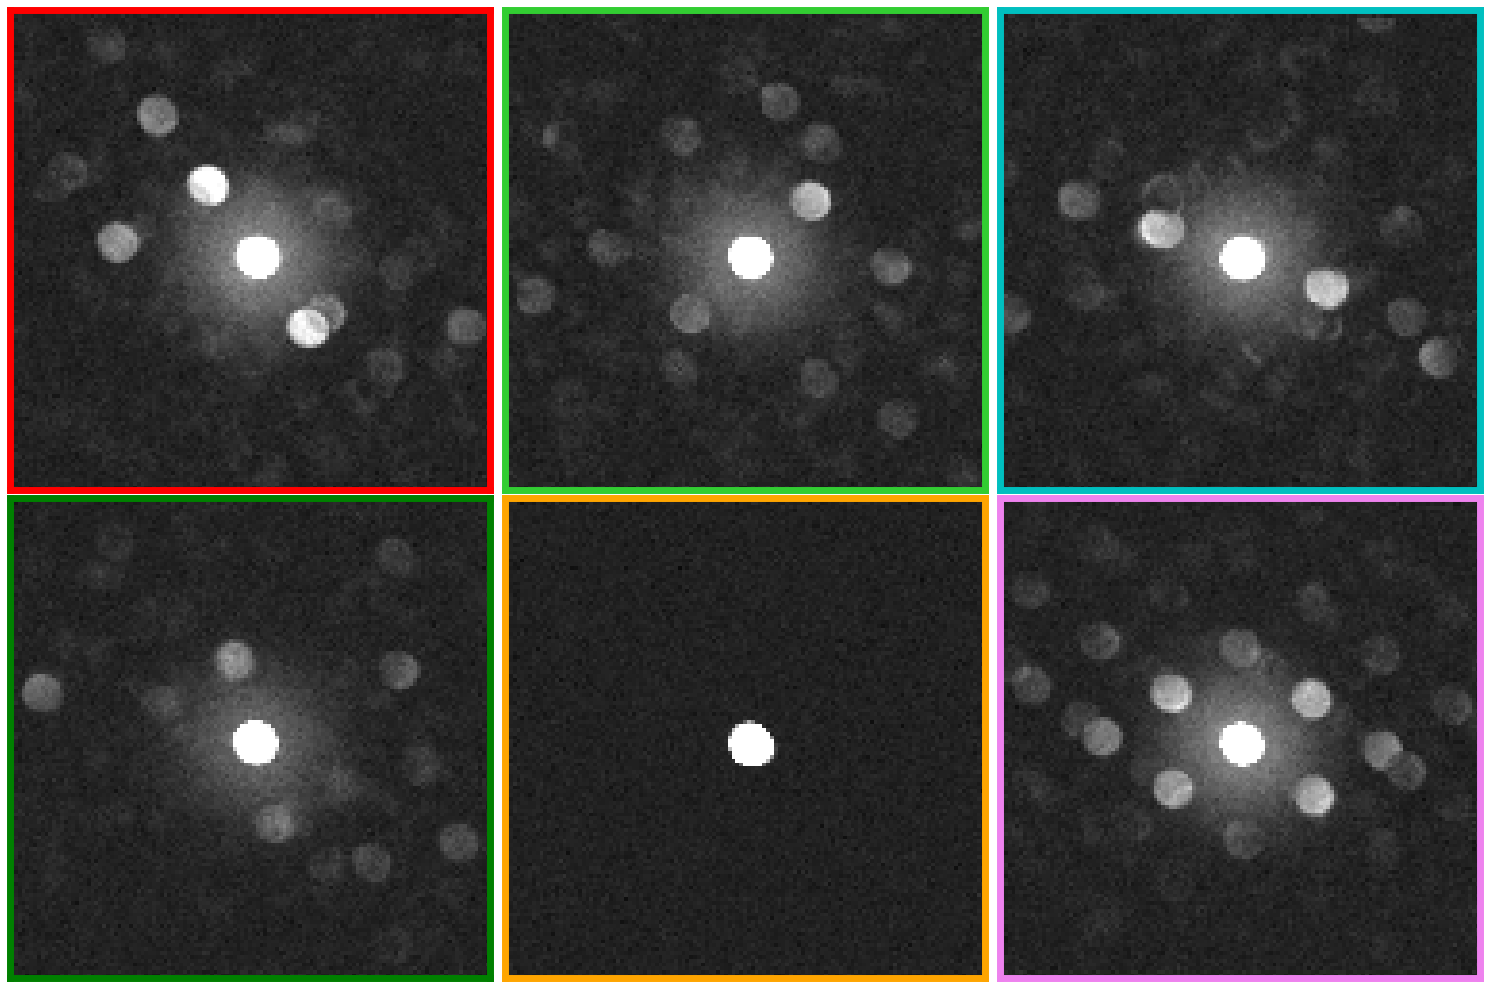

In [14]:
# Select a few sample patterns for parameter tuning


# set scan positions
rxs = 36,15,11,59,32,34
rys = 9,15,31,39,20,68,


colors=['r','limegreen','c','g','orange', 'violet']

# show the selected real space positions
py4DSTEM.visualize.show_points(
    basics_01.tree('bright_field'),
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# show the selected diffraction patterns
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
)

In [15]:
datacube.root.metadata['calibration']

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
)

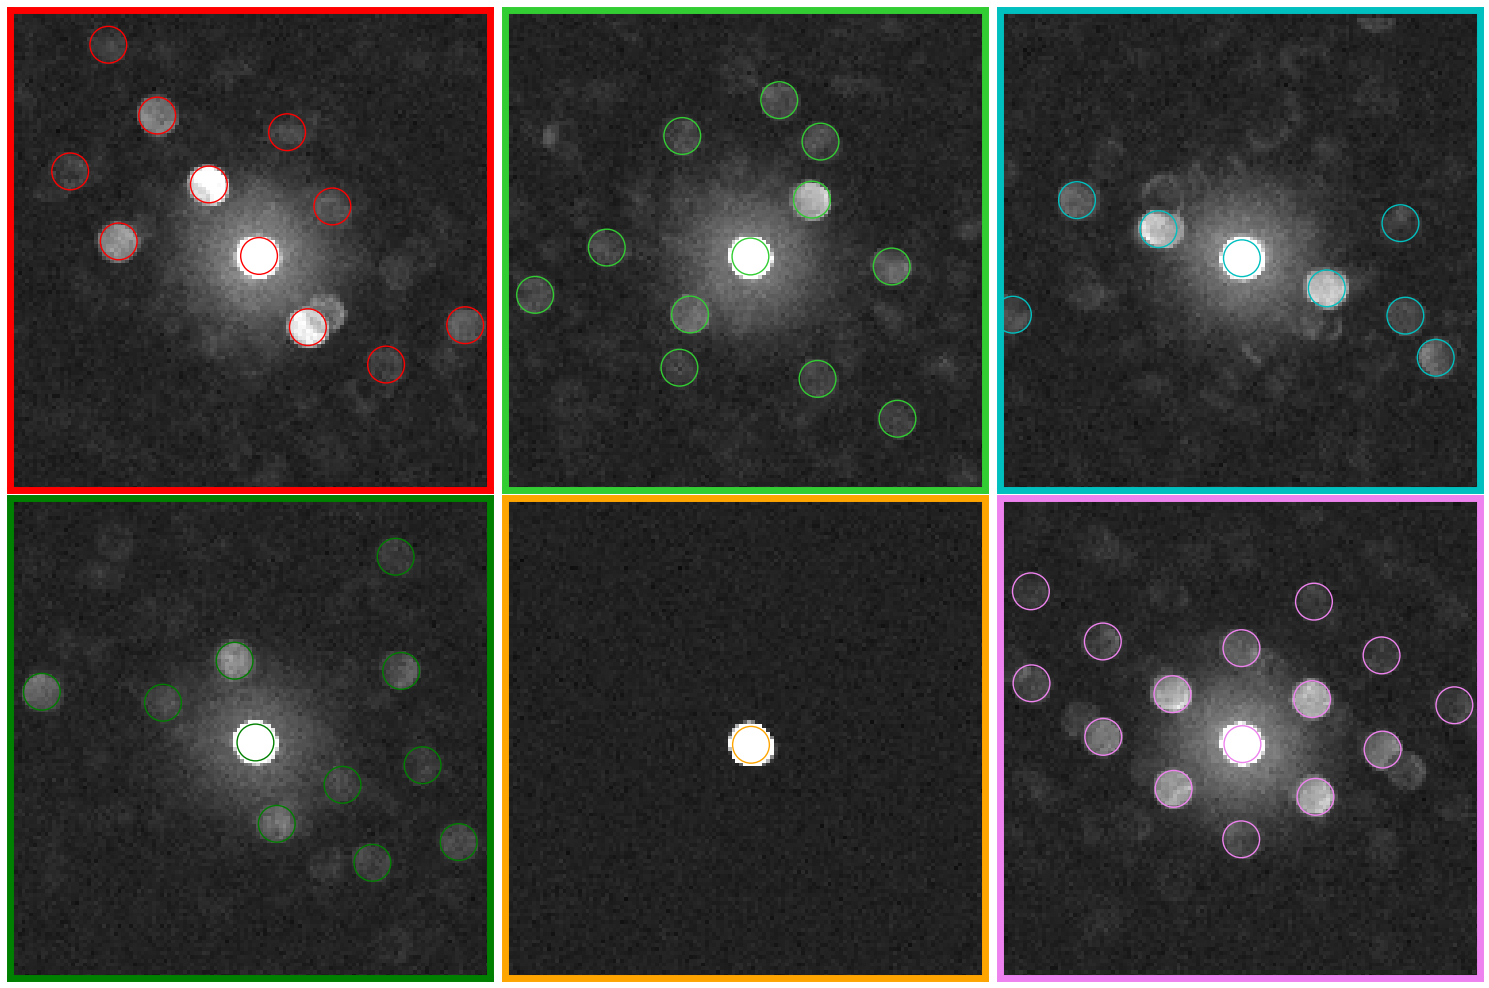

In [16]:
# Choose disk detection parameters


# set parameters

detect_params = {
    'minAbsoluteIntensity': 8,   # intensity threshold
    'minRelativeIntensity': 0,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 4,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 2,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 0,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 100,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'poly',         # subpixel resolution method
    'corrPower': 1.0,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
#     'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
}



# find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [17]:
# compute for all diffraction patterns

braggpeaks = datacube.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|███████████████████████████████████████████████| 8.40k/8.40k [00:14<00:00, 571DP/s]


In [18]:
braggpeaks.raw[0,0]

BVects( A set of 8 bragg vectors. Access data with .qx, .qy, .I, or .data.)

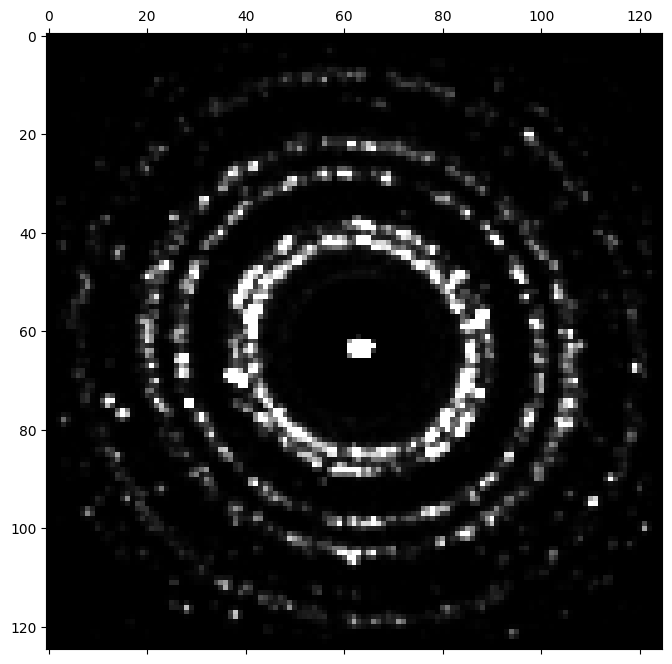

In [19]:
# compute the bragg vector map

bvm = braggpeaks.histogram( mode='raw' )

show(bvm)

# Write and read

In [20]:
# set a filepath

filepath = splitext(filepath_data)[0] + '_analysis_basics_02.h5'
filepath

'/Users/Ben/work/data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/data_binned_analysis_basics_02.h5'

In [21]:
# inspect what's in `datacube`'s  tree

datacube.tree()

/
|---probe
|---braggvectors


In [22]:
# save everthing except the datacube

py4DSTEM.save(
    filepath,
    datacube,
    tree = None,  # everything *under* datacube, but not not datacube itself
    mode = 'o'
)

100%|██████████████████████████████████████████████████████████████████| 8400/8400 [00:01<00:00, 4792.52it/s]


In [23]:
# inspect the resulting HDF5 file

py4DSTEM.print_h5_tree(filepath)

/
|---polyAu_4DSTEM
    |---braggvectors
    |   |---_v_uncal
    |---probe




In [24]:
# Load the prior analysis

basics_02 = py4DSTEM.read(
    filepath
)

basics_02.tree()

Reading PointListArray: 100%|███████████████████████████████████| 8400/8400 [00:01<00:00, 4328.60PointList/s]

/
|---braggvectors
|---probe
